*The focus of this notebook is to get the data, clean the data, and run a baseline LSTM model on it.*

# Importing Libraries

Getting necessary imports for baseline.

In [ ]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import re 

# Pytorch Imports
import torch 
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# TensorFlow utilities and sklearn for train test split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split 

#Set random seed
torch.manual_seed(1)
np.random.seed(1) 

from sklearn.metrics import r2_score as r2

# 1 Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

# Where the files were uploaded
root_dir = '/content/drive/My Drive/EngSci2/S1F/APS360/Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_excel("CLEAR_corpus_final.xlsx")

In [ ]:
data

,ID,Author,Title,Anthology,URL,Pub Year,Categ,Sub Cat,Lexile Band,Location,...,BT_easiness,s.e.,Flesch-Reading-Ease,Flesch-Kincaid-Grade-Level,Automated Readability Index,SMOG Readability,New Dale-Chall Readability Formula,CAREC,CAREC_M,CML2RI
0,400,Carolyn Wells,Patty's Suitors,NaN,http://www.gutenberg.org/cache/epub/5631/pg563...,1914.0,Lit,NaN,900,mid,...,-0.340259,0.464009,81.70,5.95,7.37,8.0,6.55,0.12102,0.11952,12.097815
1,401,Carolyn Wells,Two Little Women on a Holiday,NaN,http://www.gutenberg.org/cache/epub/5893/pg589...,1917.0,Lit,NaN,700,mid,...,-0.315372,0.480805,80.26,4.86,4.16,7.0,6.25,0.04921,0.04921,22.550179
2,402,Carolyn Wells,Patty Blossom,NaN,http://www.gutenberg.org/cache/epub/20945/pg20...,1917.0,Lit,NaN,900,mid,...,-0.580118,0.476676,79.04,6.03,5.81,9.0,7.31,0.10172,0.09724,18.125279
3,403,CHARLES KINGSLEY,THE WATER-BABIES\nA Fairy Tale for a Land-Baby,NaN,http://www.gutenberg.org/files/25564/25564-h/2...,1863.0,Lit,NaN,1300,mid,...,-1.785965,0.526599,44.77,20.51,24.87,12.0,8.56,0.07491,0.08856,10.959460
4,404,Charles Kingsley,HOW THE ARGONAUTS WERE DRIVEN INTO THE UNKNOWN...,The Heroes\n or Greek Fairy Tales for my...,http://www.gutenberg.org/files/677/677-h/677-h...,1889.0,Lit,NaN,1300,mid,...,-1.054013,0.450007,68.07,12.06,15.47,8.0,7.00,0.06356,0.08798,3.195960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4719,8027,wikijunior,Bugs/Monarch butterfly,"""Wikijunior\n",https://en.wikibooks.org/wiki/Wikijunior:Bugs/...,2019.0,Info,Science,410L-600L,start,...,0.423388,0.511439,87.37,3.59,4.37,7.0,6.71,0.13576,0.12908,19.271483
4720,8028,wikijunior,Bugs/Walking Stick,"""Wikijunior\n",https://en.wikibooks.org/wiki/Wikijunior:Bugs/...,2020.0,Info,Science,610L-800L,start,...,-0.614142,0.475506,85.42,4.02,4.32,7.0,7.62,0.08258,0.05378,15.814468
4721,8029,wikijunior,Bugs/Black Widow,Wikijunior\n,https://en.wikibooks.org/wiki/Wikijunior:Bugs/...,2020.0,Info,Science,610L-800L,start,...,0.310336,0.508939,81.36,4.60,5.32,8.0,6.92,0.10992,0.08300,22.731214
4722,8030,wikijunior,Solids,Wikijunior\n,https://en.wikibooks.org/wiki/Geometry_for_Ele...,2014.0,Info,Science,610L-800L,start,...,-0.215279,0.514128,75.83,5.89,5.84,9.0,7.74,0.18951,0.19583,16.386932


In [ ]:
data['Excerpt']

0       When the young people returned to the ballroom...
1       All through dinner time, Mrs. Fayre was somewh...
2       As Roger had predicted, the snow departed as q...
3       Mr. Grimes was to come up next morning to Sir ...
4       And outside before the palace a great garden w...
                              ...                        
4719    The name Monarch means “king”. An adult Monarc...
4720    Walking Sticks are long, thin, and slow-moving...
4721    A Black Widow is a shiny black spider. It has ...
4722    Solids are shapes that you can actually touch....
4723    Animals are made of many cells. They eat thing...
Name: Excerpt, Length: 4724, dtype: object

In [ ]:
data["BT_easiness"]

0      -0.340259
1      -0.315372
2      -0.580118
3      -1.785965
4      -1.054013
          ...   
4719    0.423388
4720   -0.614142
4721    0.310336
4722   -0.215279
4723    0.300779
Name: BT_easiness, Length: 4724, dtype: float64

Let's take a look at the distribution for BT_easinesss to see if normalizing the labels makes sense.

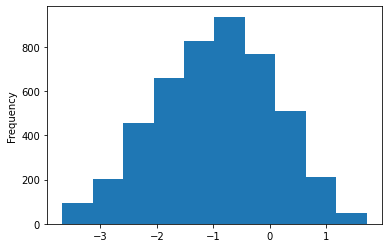

In [ ]:
data["BT_easiness"].plot.hist()

# 2 Data Cleaning and Tokenization

Even though readability relies on punctuation, the baseline model will not use it.

In [ ]:
glove = torchtext.vocab.GloVe(name = "6B", dim = 100, max_vectors=30000)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 29999/30000 [00:01<00:00, 21966.71it/s]


In [ ]:
def tokenize_df(excerpts, target):
  tokenizer = torchtext.data.utils.get_tokenizer("basic_english")
  token_series = excerpts.apply(lambda x: tokenizer(x))
  df = pd.concat([token_series, target], axis=1)

  return df

In [ ]:
data_tok = tokenize_df(data["Excerpt"],data["BT_easiness"])

In [ ]:
data_tok

,Excerpt,BT_easiness
0,"[when, the, young, people, returned, to, the, ...",-0.340259
1,"[all, through, dinner, time, ,, mrs, ., fayre,...",-0.315372
2,"[as, roger, had, predicted, ,, the, snow, depa...",-0.580118
3,"[mr, ., grimes, was, to, come, up, next, morni...",-1.785965
4,"[and, outside, before, the, palace, a, great, ...",-1.054013
...,...,...
4719,"[the, name, monarch, means, “king”, ., an, adu...",0.423388
4720,"[walking, sticks, are, long, ,, thin, ,, and, ...",-0.614142
4721,"[a, black, widow, is, a, shiny, black, spider,...",0.310336
4722,"[solids, are, shapes, that, you, can, actually...",-0.215279


As in tutorial, we will get the indexes of each word in a PyTorch tensor.

## Normalizing Labels

Let's normalize BT_easiness to be between -1 and 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler  

scaler = MinMaxScaler((0, 1))
data_tok['BT_easiness'] = scaler.fit_transform(data_tok[['BT_easiness']])

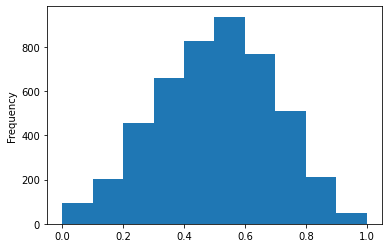

In [ ]:
data_tok['BT_easiness'].plot.hist()

In [ ]:
#@title
from sklearn.preprocessing import MinMaxScaler  

scaler = MinMaxScaler((0, 1))

data_normalized = data.copy()
data_normalized['BT_easiness'] = scaler.fit_transform(data[['BT_easiness']])

(data_normalized.loc[(data_normalized['BT_easiness'] < 0.1)]['Excerpt'])[695]

## GloVe Embeddings

In [ ]:
def get_excerpt_idx(glove_vec, data):
  train, valid, test = [], [], []
  concat = []

  for i, row in enumerate(data["Excerpt"]): 
    # Get the index of the word, provided in exists within the GloVe corpus
    idxs = [glove_vec.stoi[tok]
            for tok in row
            if tok in glove_vec.stoi]

    # Convert to tensors
    idxs = torch.tensor(idxs)
    labels = torch.tensor(data["BT_easiness"][i])   

    concat.append((idxs,labels))

  # Split into training, validation and testing
  train, valid_test = train_test_split(concat, test_size = 0.2, random_state = 1)
  valid, test = train_test_split(valid_test, test_size = 0.2, random_state = 1)

  return train, valid, test 

In [ ]:
train_set, valid_set, test_set = get_excerpt_idx(glove, data_tok)

In [ ]:
excerpt, label = train_set[0]
print(excerpt)
print(label)

tensor([   61,     0, 10384,    15,  2846,    60,    67, 19779,    71,   629,
           48,  1738,     4,   886,    71,   242,    66,     5,   190,     7,
         2385,   106,     0,  3076,    17,    71,  1955,     2,     0,   629,
            1,    34,  4592,    15,    67,    66,     3,     0,  1888,    61,
         3709,     7,  7394,   263,   135,    25,     0,  3505,     1,  2436,
            0, 10384,    25,   244,    71,  1955,     1,     5,  1236,    71,
          420,    17,   103,   152,    75,     0,  7703,     2,     0,  1955,
         4839,   137,     4,    44,   629,     1,   154,   103,     3,    44,
        24614,     1,     5, 19779,  4247,     4,   242,     5,  1762,    44,
         4705,  2003,     2,     0,   629,     1,   646,   101,   236,     7,
         2867,     5,  1174,    10,     7,  3930,     1,     5,    39,   208,
           66,     2,    49,   109,    39,   263,   531,     7,    42,  2097,
         2242,    13,  1828,  2094,     6,  6859,     2,    61, 

## Embedding Layer

In [ ]:
glove_emb = nn.Embedding.from_pretrained(glove.vectors) 

ex_emb = glove_emb(excerpt)
ex_emb.shape

torch.Size([161, 100])

# 3 LSTM Model

In [ ]:
class baseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(baseLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

## Padding and Batching

In [ ]:
import random

class exBatcher:
    def __init__(self, excerpts, batch_size=32, drop_last=False):
        # store excerpts by length
        self.excerpts_by_length = {}
        for words, label in excerpts:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.excerpts_by_length:
                self.excerpts_by_length[wlen] = []
            self.excerpts_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of excerpts of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    excerpts,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, excerpts in self.excerpts_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [ ]:
train_set, valid_set, test_set = get_excerpt_idx(glove, data_tok)
batch_size = 32
num_workers = 1
train_loader = exBatcher(train_set, batch_size = 64, drop_last = True)
valid_loader = exBatcher(valid_set, batch_size = 64, drop_last = True)
test_loader = exBatcher(test_set, batch_size = 64, drop_last = True)

# 4 Training

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 7.3 MB/s 


In [ ]:
# def get_accuracy(model, data_loader):
  #  R_total, total = 0, 0
   # for excerpts, labels in data_loader:
    #      output = torch.flatten(model(excerpts.data))
    #      R = r2(labels, output.detach())
    #      R_total += R
     #     total += 1
        
        #  dist = (output.data - labels).pow(2).sum()
        #  square_labels = labels.pow(2).sum()
         # R = 1 - dist / square_labels
         # R_total += R
        #  total += 1
 #   try:
   #   return R_total / total
  #  except:
   #   return 0
  #  return R_total / total

from torchmetrics import MeanSquaredError

def get_rmse(model, data_loader):
  mean_squared_error = MeanSquaredError()   
  running_rmse = 0.0
  for excerpts, labels in data_loader:
    outputs = (torch.flatten(model(excerpts.data)))
    running_rmse += np.sqrt((mean_squared_error(outputs, labels)).detach().numpy())

  return running_rmse/batch_size

def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mean_squared_error = MeanSquaredError()   

    losses, train_rmse, val_rmse = [], [], []
    epochs = []

    for epoch in range(num_epochs):

        running_rmse = 0.0
        for excerpts, labels in train:
            optimizer.zero_grad()
            pred = model(excerpts)
            loss = criterion(pred, labels.float())
            loss.backward()
            optimizer.step()  
            running_rmse += np.sqrt((mean_squared_error(torch.flatten(pred), labels)).detach().numpy())
      
        losses.append(float(loss))
        epochs.append(epoch)
        train_rmse.append(running_rmse/batch_size)
        val_rmse.append(get_rmse(model, train_loader))

        print("Epoch %d; Loss %f; Train RMSE %f; Val RMSE %f" % (
              epoch+1, loss, train_rmse[-1], val_rmse[-1]))
        
        torch.save(model.state_dict(), "curr_model") 

    # plotting
    plt.title("Training Loss")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_rmse, label="Train")
    plt.plot(epochs, val_rmse, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")
    plt.legend(loc='best')
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1; Loss 0.122136; Train RMSE 0.161803; Val RMSE 0.139264
Epoch 2; Loss 0.089876; Train RMSE 0.121544; Val RMSE 0.103332
Epoch 3; Loss 0.046086; Train RMSE 0.092145; Val RMSE 0.079124
Epoch 4; Loss 0.052087; Train RMSE 0.075511; Val RMSE 0.073340
Epoch 5; Loss 0.036628; Train RMSE 0.073208; Val RMSE 0.074606
Epoch 6; Loss 0.035764; Train RMSE 0.073755; Val RMSE 0.072967
Epoch 7; Loss 0.052888; Train RMSE 0.074433; Val RMSE 0.074492
Epoch 8; Loss 0.032884; Train RMSE 0.073985; Val RMSE 0.074241
Epoch 9; Loss 0.037158; Train RMSE 0.074293; Val RMSE 0.072783
Epoch 10; Loss 0.035166; Train RMSE 0.073338; Val RMSE 0.073706
Epoch 11; Loss 0.038242; Train RMSE 0.073403; Val RMSE 0.073744
Epoch 12; Loss 0.045777; Train RMSE 0.073822; Val RMSE 0.072704
Epoch 13; Loss 0.038062; Train RMSE 0.073497; Val RMSE 0.073140
Epoch 14; Loss 0.042416; Train RMSE 0.073448; Val RMSE 0.073587
Epoch 15; Loss 0.051377; Train RMSE 0.072579; Val RMSE 0.072665


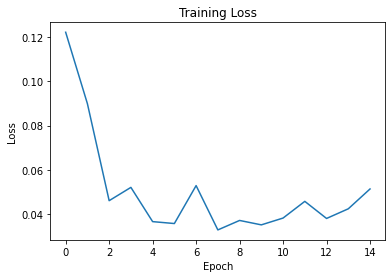

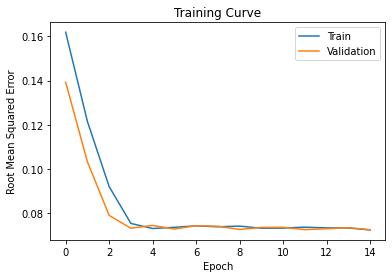

0.0

In [ ]:
model = baseLSTM(100, 100, 1)
train_rnn_network(model, train_loader, valid_loader, num_epochs=15, learning_rate=0.0001)
get_rmse(model, test_loader)

# 5 Model Evaluation

Let's perform some quick qualitative evaluation on two example texts.

In [ ]:
def get_normalized_bt(text, model, glove_vec):
  tokenizer = torchtext.data.utils.get_tokenizer("basic_english")
  # Get the index of the word, provided in exists within the GloVe corpus
  idxs = [glove_vec.stoi[tok]
          for tok in tokenizer(text)
          if tok in glove_vec.stoi]

  # Convert to tensors
  idxs = torch.tensor(idxs) 
  pred = model(idxs.unsqueeze(0))

  return pred

In [ ]:
get_normalized_bt("Hitler was born in Braunau am Inn in Austria-Hungary and was raised near Linz. He lived in Vienna later in the first decade of the 1900s and moved to Germany in 1913. He was decorated during his service in the German Army in World War I. In 1919, he joined the German Workers' Party (DAP), the precursor of the Nazi Party, and was appointed leader of the Nazi Party in 1921. In 1923, he attempted to seize governmental power in a failed coup in Munich and was imprisoned with a sentence of five years. In jail, he dictated the first volume of his autobiography and political manifesto Mein Kampf (My Struggle). After his early release in 1924, Hitler gained popular support by attacking the Treaty of Versailles and promoting pan-Germanism, anti-Semitism and anti-communism with charismatic oratory and Nazi propaganda. He frequently denounced international capitalism and communism as part of a Jewish conspiracy.", model, glove)

tensor([[0.4099]], grad_fn=<AddmmBackward0>)

In [ ]:
data_normalized = data.copy()
data_normalized['BT_easiness'] = scaler.fit_transform(data[['BT_easiness']]) 
np.mean(data_normalized.loc[(data_normalized['BT_easiness'] > 0.38) & (data_normalized['BT_easiness'] < 0.39)]['Flesch-Kincaid-Grade-Level'])

11.443

In [ ]:
get_normalized_bt("The sun did not shine. It was too wet to play. SO we sat in the house all that cold, cold, wet day. I sat there with Sally. We sat there, we two. ANd I said, HOw I wish We had something to do! To wet to go out, and too cold to play ball. So we sat in the house. We did nothing at all. We looked! Wo all we could do was sit. ANd we did not like it. Not one little bit.  I know it is wet and the sun is not sunny but we can have lots of good fun that is funny! I know some good games we could play, said the cat. I know some new tricks, said the cat in the hat. A lot of good tricks. I will show them to you. YOur mother will not mind at all if I do.", model, glove)

tensor([[0.5813]], grad_fn=<AddmmBackward0>)

In [ ]:
np.mean(data_normalized.loc[(data_normalized['BT_easiness'] > 0.31) & (data_normalized['BT_easiness'] < 0.32)]['Flesch-Kincaid-Grade-Level'])

12.938627450980393

In [ ]:
get_normalized_bt("Near the top of the world is land called tundra. The tundra is flat and has no trees. It is covered by snow and ice most of the year. In the spring, the snow and ice melt. Beneath the ground, the soil stays frozen. The ground gets very soggy. It is a marsh. Small yellow flowers grow from the cold, wet ground. They are called marsh marigolds. Flies hide in the flowers. They soak up the Sun’s energy and get warm. The flies fly from flower to flower. They help the flowers make seeds. Caribou eat the flowers. The caribou also give the plants the nutrients they need to grow. Mother flies lay their eggs inside the caribou’s nose. It is warm there. The young flies eat and grow. The young flies get bigger. AH-CHOO! The caribou sneezes. The flies land on the ground. Soon, they will be adults. These plants and animals need each other. Can you think of others?", model, glove)

tensor([[0.4805]], grad_fn=<AddmmBackward0>)